In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
hurrloc = "../data/track_data/SANDY_2012"

df = pd.read_csv(hurrloc, skiprows=1)
hermlen = len(df[df.columns[0]])

hurrnum = np.ones(hermlen)
for i in range(hermlen):
    yearmoda = str(df[df.columns[0]][i])
    hours    = int(df[df.columns[1]][i]/100)
    dateform = datetime.datetime(int(yearmoda[:4]), int(yearmoda[4:6]), int(yearmoda[6:]), hours)
    hurrnum[i] = mdates.date2num(dateform)

latsN, lonsN = df.columns[4], df.columns[5]

hurrlats = [float(df[latsN][i][:-1]) for i in range(len(df[df.columns[0]]))]
hurrlons = [-float(df[lonsN][i][:-1]) for i in range(len(df[df.columns[0]]))]

In [3]:
dataloc = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20121025T000000_20121105T000000_maracoos_ru23.nc"

In [4]:
df = xr.open_dataset(dataloc)

In [5]:
df

<xarray.Dataset>
Dimensions:      (depth: 60, profile: 3046)
Coordinates:
    time         (profile) datetime64[ns] ...
  * depth        (depth) float64 -1.0 -3.0 -5.0 -7.0 ... -115.0 -117.0 -119.0
Dimensions without coordinates: profile
Data variables:
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    temperature  (profile, depth) float64 ...
    salinity     (profile, depth) float64 ...
    BB470        (profile, depth) float64 ...
    BB532        (profile, depth) float64 ...
    BB660        (profile, depth) float64 ...
Attributes:
    Conventions:                     CF-1.0
    Title:                           Rutgers University COOL glider data on s...
    source:                          
    Institution:                     Institute for Marine and Coastal Science...
    history:                         Created by /home/om/cron/glider/glider_h...
    DODS_EXTRA.Unlimited_Dimension:  profile

In [6]:
from geopy.distance import geodesic

glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

In [7]:
b = np.amin(distance_metric)
print(b)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrnum[ktime]
eyepassage

41.397151792232734


15642.958333333334

In [8]:
df['mdate'] = mdates.date2num(df.time)

In [9]:
start = mdates.date2num(datetime.datetime(2012,10,28))
enddd = mdates.date2num(datetime.datetime(2012,10,30,12))

In [10]:
D, MDATE = np.meshgrid(df.depth.values,df.mdate.values)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


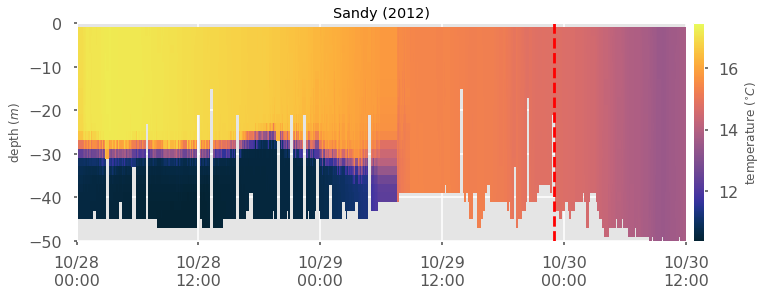

In [13]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, df.temperature, cmap=cmo.thermal)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-50,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.grid()
plt.title('Sandy (2012)')
plt.savefig("FIGS/temperatures_Sandy2012.pdf", bbox_inches='tight')
plt.show()

In [183]:
btm_att = eyepassage-16/24

In [185]:
df.depth.values
bef = df.mdate.values < btm_att-0.5
aft = df.mdate.values > btm_att-2.5
qb   = np.logical_and(bef,aft)

In [186]:
TEMPS = df.temperature.values
times = df.mdate.values

In [187]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(df.temperature.values-T0) + beta*(df.salinity.values-S0))
buoy  = -g * dense / dense0

dz = np.gradient(df.depth.values)
db = np.gradient(buoy, axis=[1])
dbdz = -db/dz

dbdz_b = dbdz[qb,:]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[0])
for i in range(dbdz_b.shape[0]):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
np.nanmean(maxN2)

0.0011734110620421768

In [98]:
st = mdates.date2num(datetime.datetime(2012,10,28,0))
en = mdates.date2num(datetime.datetime(2012,10,28,18))

a = times < en
b = times > st
q = np.logical_and(a,b)
temps_before = TEMPS[q,:]
temps_before = np.nanmean(temps_before, axis=(0))

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


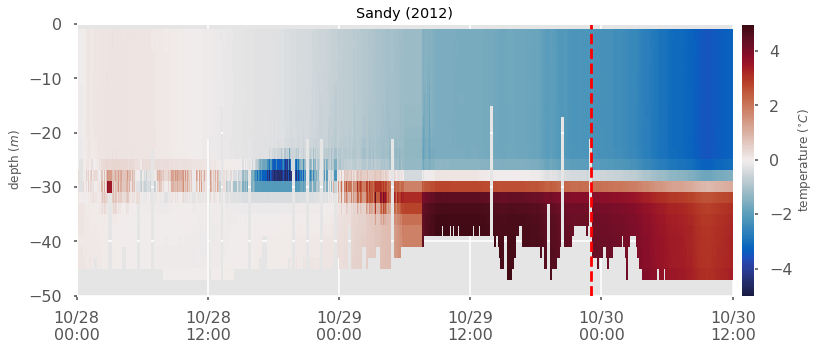

In [99]:
plt.figure(figsize=(14,5))
plt.pcolor(MDATE, D, df.temperature.values - temps_before[np.newaxis,:], cmap=cmo.balance, vmin=-5, vmax=5)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-50,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.xlim([start, enddd])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.title('Sandy (2012)')
plt.savefig("FIGS/dT_Sandy2012.pdf", bbox_inches='tight')
plt.show()

In [160]:
df.depth.values
bef = df.mdate.values < eyepassage-0.5
aft = df.mdate.values > eyepassage-3.5
qb   = np.logical_and(bef,aft)
temps_bef = df.temperature.values[qb,:3]
mean_Tbef = np.nanmean(temps_bef)

bef = df.mdate.values < eyepassage+(1/24)
aft = df.mdate.values > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = df.temperature.values[qeye,:3]
mean_Teye = np.nanmean(temps_eye)

bef = df.mdate.values < eyepassage+0.5
aft = df.mdate.values > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = df.temperature.values[qa,:3]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

2.069595027325997 1.001360781879189


In [143]:
winddata = "../data/ndbc_years/44065h2012.txt"
winddat2 = "../data/ndbc_years/44009h2012.txt"

ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(winddat2, skiprows=[1], delim_whitespace=True)

ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

In [171]:
eye65 = eyepassage-1.3/24
eye09 = eyepassage-2.1/24

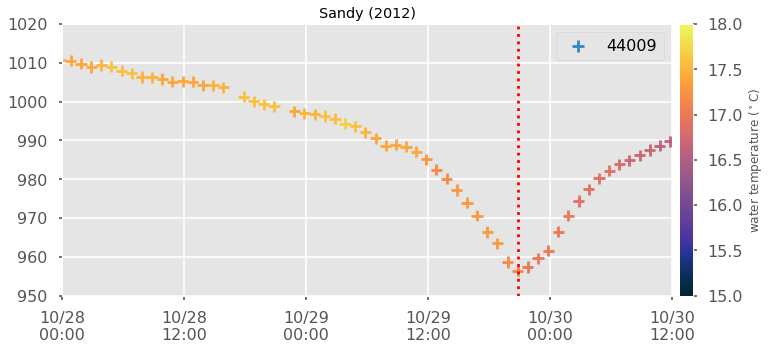

In [170]:
plt.figure(figsize=(13,5))
#plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], vmin=15, vmax=18, cmap=cmo.thermal, marker=".", label="44065")
plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=15, vmax=18, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='water temperature ($^\circ$C)')
plt.xlim([start, enddd])
plt.legend()
plt.axvline(x = eyepassage-2.1/24, c='r', linestyle=":")
plt.ylim([950,1020])
plt.title('Sandy (2012)')
plt.gca().xaxis.set_major_formatter(myFmt)

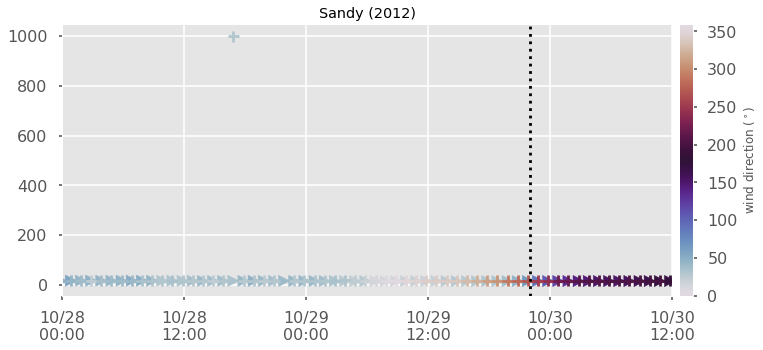

In [174]:
wtemp = ndb['WTMP'].values
wtemp[wtemp > 35] = np.nan

plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker=">", label="44065", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.scatter(nd2_datenum,nd2['WTMP'], marker="+", label="44009", c=nd2['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.axvline(x = eyepassage-1/24, c='k', linestyle=":")
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([start, enddd])
#plt.ylim([14,18])
plt.title('Sandy (2012)')
plt.gca().xaxis.set_major_formatter(myFmt)

In [175]:
def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmedian(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmedian(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmedian(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

In [176]:
cooling_defs_1D(ndb_datenum,eye65,ndb['WTMP'].values)

(0.7999999999999989, -0.15000000000000036)

In [177]:
cooling_defs_1D(nd2_datenum,eye65,nd2['WTMP'].values)

(0.4499999999999993, 0.1999999999999993)